# PROJECT: Course Optimization for Data Science 2023-2024
## Optimization strategies for the multiclass multinomial logistic regression with non-smooth penalties


Author: Alexandre Gramfort

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- Derive mathematically and implement the loss and gradients of the multinomial logistic regression model
- Implement your own solvers for L1, L2 and L1/L2 regularizations with: (Accelerated) Proximal gradient descent, proximal coordinate descent and L-BFGS (only for L2)
- Implement your own scikit-learn estimator for the multinomial logistic regression model and test it on the `digits` dataset.


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 21st of January 2024 at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "marius"
ln1 = "ortega"
fn2 = "wiam"
ln2 = "adnan"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_ortega_marius_and_adnan_wiam.ipynb


Some imports

In [2]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt

## Part 0: Multinomial logistic regression model

This model is a multinomial logistic regression model. It is a supervised learning model, in the case where the target space $\mathcal{Y}$ is discrete: $\mathcal{Y}=\{1, \dots, K\}$; this is a multiclass classification model.

We consider a sample $x \in \mathbb{R}^{P}$ belonging to $K$ possible classes.

We want to solve the classification task, _i.e.,_ learn the parameters $\theta = (\mathbf{W}, \mathbf{b}) \in \mathbb{R}^{P\times K}\times \mathbb{R}^{K}$ of the function $f_\theta: \mathbb{R}^P \to [0, 1]^K$ which corresponds for each coordinate to the probability of being from one class.

The model is defined as
$$
[f_\theta(x)]_k = \mathbb{P}[Y=k | x] = \frac{1}{Z} \exp(w_k^\top x + b_k) \enspace ,
$$
where $w_k$ corresponds to the kth column of $W$, and $Z$ is a normalizing constant.

As these probabilities must sum to one, we get
$$
Z = \sum_{k=1}^K \exp(w_k^\top x + b_k).
$$
We can recognize the so-called _soft-max_ function: $[\sigma(z)]_i = \frac{e^{z_i}}{\sum_{k=1}^K e^{z_k}}$.

After one-hot encoding of the target variable ([`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), denoting $\{ y_{ik} \}_{k=1}^{K}$ the indicator sequence for the class of the $i^{\text{th}}$ observation $x_i$ (i.e., if the sample $i$ belongs to class $k$, then $y_{ik} = 1$ and $y_{ik'}=0$ for $k'\neq k$) the negative log likelihood (**nll**, _a.k.a_ cross-enropy loss) becomes:
$$
L(W, b) = - \frac1N \sum_{i=1}^N \log(\mathbb{P}[Y=y_i | x_i]) = -\frac1N \sum_{i=1}^N \log\Bigg(\frac{\exp(w_{y_i}^\top x_i + b_{y_i})}{\sum_{k=1}^K \exp(w_k^\top x_i+ b_k)}\Bigg) \enspace .
$$

**Note:** The notation $w_{y_i}$ means the column of $W$ whose index corresponds to the class value (e.g. 1, 2, ..., K) for the sample $x_i$.

Using the softmax function, we can also rewrite this as
$$
L(W, b) =  -\frac1N \sum_{i=1}^N \log([\sigma(Wx_i + b)]_{y_i})
$$

Introducing some regularization on the parameter $W$ with parameter $\lambda \ge 0$, the penalized likelihood estimation problem is written:

$$
    (\mathcal{P}):
	\min_{W, b} \quad L(W, b) + \lambda \mathcal{R}(W)
$$

where $\mathcal{R}(W)$ can be :
- $\mathcal{R}_1(W) = \|W\|_1 = \sum_{j=1}^P \sum_k^K |W_{jk}|$, ie. an $\ell_1$ norm
- $\mathcal{R}_2(W) = \tfrac{1}{2} \|W\|^2_F = \tfrac{1}{2} \sum_{j=1}^P \sum_{k=1}^K W_{jk}^2$, ie. a squared $\ell_2$ norm 
- $\mathcal{R}_{21}(W) = \|W\|_{21} = \sum_{j=1}^P \sqrt{\sum_{k=1}^K W_{jk}^2}$, ie. an $\ell_{21}$ mixed-norm. This corresponds to the $\ell_1$ norm of the sequence of $\ell_2$ norms of the rows of $W$.

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
      <li>Justify that $(\mathcal{P})$ is a convex problem for the 3 different choices of regularization.</li>
    </ul>
</div>

Justify that $(\mathcal{P})$ is a convex problem for the 3 different choices of regularization.

**Hint**: You can show that for $z\in\mathbb{R}^K$ and $1\leq j\leq K$, the function $z\to -\log(\sigma(z)_j)$ is convex.

Let : 

$$
\begin{align}
    & L(W, b) = -\frac1N \sum_{i=1}^N \log([\sigma(Wx_i + b)]_{y_i}) \\
    & \mathcal{R}_1(W) = \|W\|_1 = \sum_{j=1}^P \sum_k^K |W_{jk}| \\
    & \mathcal{R}_2(W) = \tfrac{1}{2} \|W\|^2_F = \tfrac{1}{2} \sum_{j=1}^P \sum_{k=1}^K W_{jk}^2 \\
    & \mathcal{R}_{21}(W) = \|W\|_{21} = \sum_{j=1}^P \sqrt{\sum_{k=1}^K W_{jk}^2}
\end{align}
$$

#### Convexity of $L(W, b)$ :

Let's first prove that for $z\in\mathbb{R}^K$ and $1\leq j\leq K$, the function $z\to -\log(\sigma(z)_j)$ is convex, where $\sigma(z)_j$ denotes the $j$-th component of the softmax function applied to $z$.

The softmax function is defined as:
$$ \sigma(z)_j = \frac{e^{z_j}}{\sum_{k=1}^{K} e^{z_k}} $$

For the function $-\log(\sigma(z)_j)$, we have:
$$ -\log(\sigma(z)_j) = -z_j + \log\left(\sum_{k=1}^{K} e^{z_k}\right) $$

The second term, $\log\left(\sum_{k=1}^{K} e^{z_k}\right)$, is the log-sum-exp function which is known to be convex. The first term, $-z_j$, is a linear (and therefore convex) function of $z$. The sum of convex functions is also convex, therefore $-\log(\sigma(z)_j)$ is convex.

Now, let's prove that log-sum-exp function defined by 
$$ f(x) = \log\left(\sum_{i=1}^{n} e^{x_i}\right) $$ 
for $ x \in \mathbb{R}^n $ is convex.

Let $ z $ be the vector with components $ z_i = e^{x_i} $ for $ i = 1, \ldots, n $, and let $ 1^T $ denote the transpose of a vector of ones. The gradient of $ f $ is given by the softmax function:
$$ \nabla f(x) = \frac{z}{1^T z} $$

The Hessian of $ f $, denoted $\nabla^2 f(x) $ is:
$$ \nabla^2 f(x) = \frac{1}{(1^T z)^2} \left( (1^T z) \text{diag}(z) - zz^T \right) $$

To verify that $ \nabla^2 f(x) $ is positive semi-definite, we need to show that for any vector $ v \in \mathbb{R}^n $, the quadratic form $ v^T \nabla^2 f(x) v \geq 0 $

Considering the quadratic form:
$$ v^T \nabla^2 f(x) v = \frac{1}{(1^T z)^2} \left( (1^T z) \sum_{i=1}^{n} v_i^2 z_i - \left(\sum_{i=1}^{n} v_i z_i\right)^2 \right) $$

We apply the Cauchy-Schwarz inequality, which states that for vectors $ a, b \in \mathbb{R}^n $:
$$ (a^T b)^2 \leq (a^T a)(b^T b) $$

Choosing $ a_i = v_i \sqrt{z_i} $ and $ b_i = \sqrt{z_i} $, the Cauchy-Schwarz inequality yields:
$$ \left(\sum_{i=1}^{n} v_i z_i\right)^2 \leq \left(\sum_{i=1}^{n} v_i^2 z_i\right) \left(\sum_{i=1}^{n} z_i\right) $$

Substituting into our quadratic form gives:
$$ v^T \nabla^2 f(x) v \geq 0 $$

Hence, for all $ v $, $ v^T \nabla^2 f(x) v \geq 0 $, which implies that the Hessian matrix $ \nabla^2 f(x) $ is positive semi-definite, and therefore, the log-sum-exp function $ f(x) $ is convex $ \mathbb{R}^n $.

TODO 

#### Convexity of $\mathcal{R}_1(W)$ :

We know that any norm is a convex function using the triangular inequality :

$$
\begin{align}
    & \forall (W_1, W_2) \in \mathbb{R}^{P \times K} \times \mathbb{R}^{P \times K}, \forall \lambda \in [0, 1], \\
    & \|\lambda W_1 + (1 - \lambda) W_2\|_1 \leq \lambda \|W_1\|_1 + (1 - \lambda) \|W_2\|_1
\end{align}
$$

We end up with $0^{th}$-order convexity definition, consequently, $\mathcal{R}_1(W)$ is convex.

#### Convexity of $\mathcal{R}_2(W)$ :

We know that any norm is a convex function using the triangular inequality as above, thus $\mathcal{R}_2(W)$ is convex.

#### Convexity of $\mathcal{R}_{21}(W)$ :

We know that any norm is a convex function using the triangular inequality as above, thus $\mathcal{R}_{21}(W)$ is convex.

#### Conclusion : 

We have shown that $L(W, b)$ and $\mathcal{R}_1(W)$, $\mathcal{R}_2(W)$, $\mathcal{R}_{21}(W)$ are convex functions.

We can prove that the sum of convex functions is convex, let $h = f + g$ with $f$ and $g$ convex functions, we have :

$$
\begin{align}
    f(\lambda x + (1 - \lambda) y) + g(\lambda x + (1 - \lambda) y) & \leq \lambda f(x) + (1 - \lambda) f(y) + \lambda g(x) + (1 - \lambda) g(y) \\

\end{align}
$$

Thus $h$ is convex.

Using this theorem, we can conclude that $(\mathcal{P})$ is a convex problem for the 3 different choices of regularization as being the sum of convex functions.



## Simulation

Let's first generate data under the above model, with $K=3$ classes.

In [3]:
from sklearn.preprocessing import OneHotEncoder

def plot_data(X, y, U=None, ax=None):
    if y.ndim == 1:
        y = OneHotEncoder().fit_transform(y[:, None]).toarray()
    n_classes = y.shape[1]
    class_colors = plt.get_cmap('viridis', n_classes)(range(n_classes))
    # Display the result in ax, which is created if it does not exist.
    if ax is None:
        _, ax = plt.subplots(figsize=(7, 7))
    ax.scatter(X[:, 0], X[:, 1], c=y @ class_colors)

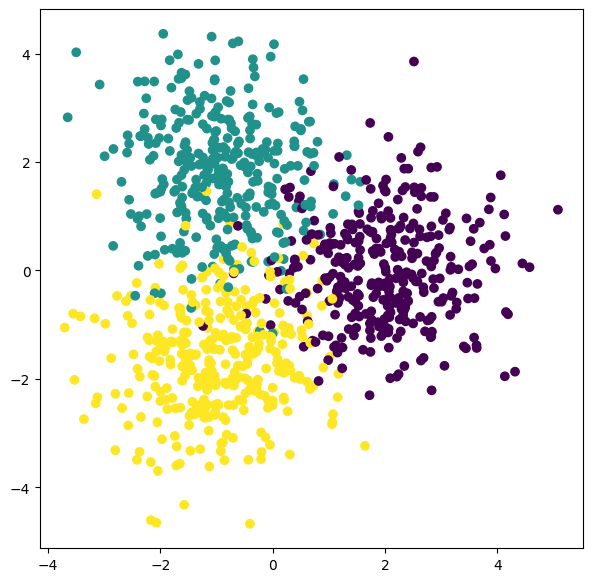

In [4]:
from sklearn.datasets import make_blobs

MU1 = (2, 0)
MU2 = (-1, np.sqrt(3))
MU3 = (-1, -np.sqrt(3))

centers = [MU1, MU2, MU3]
K = len(centers)  # number of classes
N = 1000

X, y_true = make_blobs(N, centers=centers, random_state=42)

plot_data(X, y_true)

In [5]:
X.shape, y_true.shape

((1000, 2), (1000,))

In [6]:
# One-hot encoded target
Y = OneHotEncoder().fit_transform(y_true[:, None]).toarray()
Y

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

Given some random values for $W$ and $b$, we want to compute the quantity $P(Y = k \mid x_i)$ for $k= 1, \dots , K$, and $i= 1, \dots, n$.

Note that in order to predict the label of $x$, we take the arg-maximum of the softmax values.

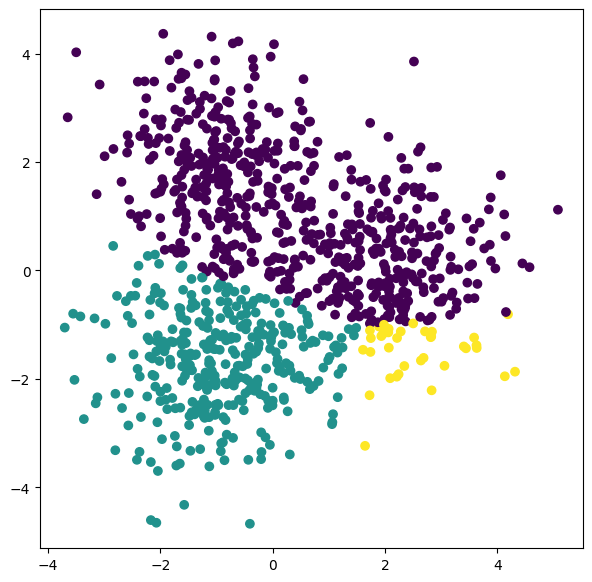

In [7]:
from scipy.special import softmax

rng = np.random.RandomState(42)
P = 2
W = rng.randn(P, K)
b = rng.randn(K)
y_proba_ = softmax(X @ W + b, axis=1)
y_ = np.argmax(y_proba_, axis=1)

plot_data(X, y_)

Note, that the sum of all probabilites for each sample is 1:

In [8]:
np.testing.assert_allclose(np.sum(y_proba_, axis=1), np.ones(N))

# Log-Likelihood function

Following the parametrization from $(\mathcal{P})$, one has `K + K*P` parameters.
We denote the stacked vector of all parameters `params`. The first `K` entries in `params` are the b and the last `K*P` entries correspond to $W$. The function that predicts the probabilities of each sample reads:

In [9]:
def predict_proba(params, X=X):
    """Compute the probability of each sample in X.
    
    Parameters:
    -----------
    params: array, shape (K + K * P,)
        Parameters of the model. The first K entries are the beta_k,
        the remaining K * P ones are the entries of W.

    X: array, shape (N, P)
        The features.

    Returns
    -------
    proba : ndarray, shape (N, K)
        The proba of belonging to each class for each sample.
    """
    _, P = X.shape
    K = len(params) // (1 + P)
    b = params[:K]
    W = params[K:].reshape(P, K)
    return softmax(X @ W + b, axis=1)

The negative log-likelihood then reads:

In [10]:
def negloglik(params, X=X, Y=Y):
    Y_proba = predict_proba(params, X)
    loss = -np.log(Y_proba[Y == 1]).mean()
    return loss

params = np.concatenate([b, W.ravel()])
negloglik(params)

2.138083050969259

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
      <li>Can you apply coordinate descent or proximal gradient descent to $(\mathcal{P})$? Justify your answer with mathematical arguments and theoretical results from the course. No coding yet!</li>
    </ul>
</div>

Can you apply coordinate descent or proximal gradient descent to $(\mathcal{P})$? Justify your answer with mathematical arguments and theoretical results from the course. No coding yet!

The problem is defined as:

$$
(\mathcal{P}):
\min_{W, b} \quad L(W, b) + \lambda \mathcal{R}(W)
$$

where $\mathcal{R}(W)$ can be either $\mathcal{R}_1(W)$ (L1-norm), $\mathcal{R}_2(W)$ (L2-norm), or $\mathcal{R}_{21}(W)$ (mixed-norm).

#### Usage of exact coordinate descent :

Based on Warga's Proposition (1963), for exact coordinate descent to converge to the global minimum $x^*$, the function $f$ must be continuously differentiable and strictly convex, and there must exist an $x^*$ in $\arg\min_{x \in X} f(x)$.

For $(\mathcal{P})$:

- L is convex and differentiable and admits a minimum (to be verified later).

- The functions $\mathcal{R}_1(W)$, $\mathcal{R}_2(W)$ and $\mathcal{R}_{21}(W)$ are convex (R2 and R21 are strictly convex not sure if R1 is strictly convex).

- The functions $\mathcal{R}_2(W)$, $\mathcal{R}_{21}(W)$ are continuously differentiable, but the function $\mathcal{R}_1(W)$ is not differentiable. 

- The functions $\mathcal{R}_1(W)$, $\mathcal{R}_2(W)$ and $\mathcal{R}_{21}(W)$ are coercive and convex, which ensures the existence of a minimum.


Coordinate descent is applicable for $\mathcal{R}_2(W)$ and $\mathcal{R}_{21}(W)$.

#### Usage of coordinate gradient descent : TO DO 

#### Usage of proximal gradient descent :

- The loss function $L$ is convex and smooth.

- The regularization terms $\mathcal{R}_1(W)$, $\mathcal{R}_2(W)$, and $\mathcal{R}_{21}(W)$ are convex.

Proximal gradient descent is applicable for all three regularization terms because it can handle non-smooth terms using proximal operators.

<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
      <li>Propose solutions for the proximal operators for the 2 regularization functions: $\mathcal{R}_1(W)$ and $\mathcal{R}_2(W)$.</li>
    </ul>
</div>

Propose solutions for the proximal operators for the 2 regularization functions: $\mathcal{R}_1(W)$ and $\mathcal{R}_2(W)$

The proximal operator for the L1 norm regularization is defined as:

$$
\text{prox}_{\lambda \|W\|_1}(V) = \arg\min_{W} \left( \frac{1}{2} \|W - V\|_2^2 + \lambda \|W\|_1 \right)
$$

Since the L1 norm is separable, we can write the objective function for each component $W_{i,k}$ of $W$:

$$
\text{prox}_{\lambda |w_{i,k}|}(v_{i,k}) = \arg\min_{w_{i,k}} \left( \frac{1}{2} (w_{i,k} - v_{i,k})^2 + \lambda |w_{i,k}| \right)
$$

The solution, known as the soft-thresholding operator, is:

$$
w_{i,k}^* =
\begin{cases} 
v_{i,k} - \lambda & \text{if } v_{i,k} > \lambda \\
0 & \text{if } |v_{i,k}| \le \lambda \\
v_{i,k} + \lambda & \text{if } v_{i,k} < -\lambda 
\end{cases}
$$

This can be compactly written as:

$$
w_{i,k}^* = \text{sign}(v_{i,k}) \max (|v_{i,k}| - \lambda, 0)
$$

The proximal operator for the L2 norm regularization is:

$$
\text{prox}_{\lambda \|W\|_2^2}(V) = \arg\min_{W} \left( \frac{1}{2} \|W - V\|_2^2 + \frac{\lambda}{2} \|W\|_2^2 \right)
$$

Differentiating the objective function with respect to $W$ and setting it to zero:

$$
\nabla_W \left( \frac{1}{2} \|W - V\|_2^2 + \frac{\lambda}{2} \|W\|_2^2 \right) = W - V + \lambda W = 0
$$

Solving for $W$ gives:

$$
W^*(1 + \lambda) = V
$$

$$
W^* = \frac{V}{1 + \lambda}
$$

Hence, the proximal operator for the L2 norm regularization scales the matrix $V$ by the factor $\frac{1}{1 + \lambda}$.


<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
      <li>Justify that the prox for the regularization function $\mathcal{R}_{21}(W)$ is written:
$$
\mathrm{prox}_{\lambda R_{21}} (W) = Z \in \mathbb{R}^{P \times K} \quad \mathrm{where} \quad Z_{i, :} =\left(1 − \frac{\lambda}{\max(\|W_{i,:}\|_2, \lambda)}\right) W_{i, :}  \enspace .
$$
         </li>
    </ul>
</div>

Justify that the prox for the regularization function $\mathcal{R}_{21}(W)$ is written:
$$
\mathrm{prox}_{\lambda R_{21}} (W) = Z \in \mathbb{R}^{P \times K} \quad \mathrm{where} \quad Z_{i, :} =\left(1 − \frac{\lambda}{\max(\|W_{i,:}\|_2, \lambda)}\right) W_{i, :}  \enspace .
$$

The notation $W_{i, :} \in \mathbb{R}^K$ stands for the ith row of $W$.

Alternatively, we can write this as

$$
Z_{i, :} = \begin{cases} 0 \text{ if } \|W_{i, :}\|_2\leq \lambda \\
(\|W_{i, :}\|_2 - \lambda)\frac{W_{i, :}}{\|W_{i, :}\|_2} \text{ otherwise}
\end{cases}
$$

**HINT:** This proximal operator is called a block thresholding. You can check that the prox for $\mathcal{R}_{21}(W)$ and $\mathcal{R}_{1}(W)$ match with $K=1$.

TO DO 
<!-- 
We know that : 

$$
prox_{\lambda R_2}(W) = W \left( 1 - \frac{\lambda}{max(\Vert W \Vert_2, \lambda)} \right)
$$

From there, we can write our proximal operator as the sum of the L2 proximal operator of each row of $W$ : 

$$
\begin{align}
    prox_{\lambda R_{21}}(X) & = \arg \min_W \left( \frac{1}{2} \Vert W - X \Vert_2^2 + \lambda \Vert W \Vert_{21} \right) \\
    prox_{\lambda R_{21}}(X) & = \arg \min_W \left( \frac{1}{2} \sum_{i=1}^P \Vert W_{i, :} - X_{i, :} \Vert_2^2 + \lambda \sum_{i=1}^P \Vert W_{i, :} \Vert_2^2 \right) \\
    prox_{\lambda R_{21}}(X) & = \sum_i^P\left(1 − \frac{\lambda}{\max(\|W_{i,:}\|_2, \lambda)}\right) W_{i, :}\\
    prox_{\lambda R_{21}}(X) & = \sum_i^P Z_{i,:} = Z
\end{align}
$$

Following the above rational we prove that the proximal operator for the regularization function $\mathcal{R}_{21}(W)$ is written:

$$
\mathrm{prox}_{\lambda R_{21}} (W) = Z \in \mathbb{R}^{P \times K} \quad \mathrm{where} \quad Z_{i, :} =\left(1 − \frac{\lambda}{\max(\|W_{i,:}\|_2, \lambda)}\right) W_{i, :}  \enspace .
$$ -->

<div class="alert alert-success">
    <b>QUESTION 5:</b>
     <ul>
      <li>Implement below the proximal operators for the 3 regularization functions: $\mathcal{R}_1(W)$, $\mathcal{R}_2(W)$ and $\mathcal{R}_{21}(W)$.</li>
    </ul>
</div>

Implement below the proximal operators for the 3 regularization functions: $\mathcal{R}_1(W)$, $\mathcal{R}_2(W)$ and $\mathcal{R}_{21}(W)$.

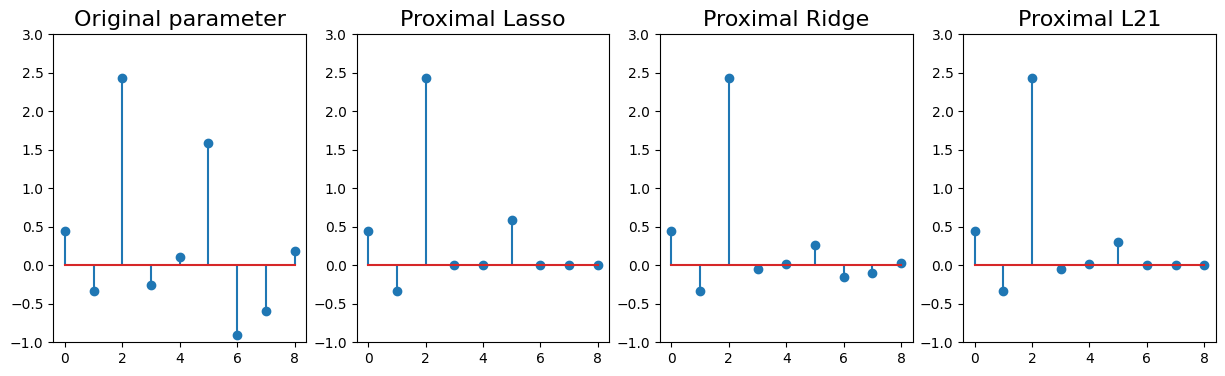

In [11]:
def prox_R2(params, reg=1., K=K):
    """Prox for R2 regularizer"""
    params = params.copy()
    W = params[K:]
    #
    W = W / (1. + reg)
    params[K:] = W
    #
    return params

def prox_R1(params, reg=1., K=K):
    """Prox for R1 regularizer"""
    params = params.copy()
    b = params[:K]
    W = params[K:].reshape(-1, K)
    #
    W = np.sign(W) * np.maximum(0, np.abs(W) - reg)
    params[:K] = b
    params[K:] = W.flatten()
    #
    return params

def prox_R21(params, reg=1., K=K):
    """Prox for R21 regularizer"""
    W = params[K:].reshape(-1, K)
    #
    W = ((1 - reg / np.maximum(reg, np.linalg.norm(W, ord=2, axis=1, keepdims=True))) * W).ravel()
    params[K:] = W
    #
    return params

# Rest of your code for plotting
rng = np.random.RandomState(5)
params = rng.randn((P + 1) * K)
l_l1 = 1.
l_l2 = 5.
l_l21 = 1.3
ylim = [-1, 3]

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 4, 1)
plt.stem(params)
plt.title("Original parameter", fontsize=16)
plt.ylim(ylim)
plt.subplot(1, 4, 2)
plt.stem(prox_R1(params, l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim(ylim)
plt.subplot(1, 4, 3)
plt.stem(prox_R2(params, l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim(ylim)
plt.subplot(1, 4, 4)
plt.stem(prox_R21(params, l_l21))
plt.title("Proximal L21", fontsize=16)
plt.ylim(ylim)

plt.show()

**Note:** You see that the proximal operator does not affect the first 3 entries which correspond to the variable `b` which is not regularized.

## Part 1: Implementation of the solvers

### L-BFGS-B Solver

We will start by using the L-BFGS solver provided by `scipy`. To do this you will first propose a mathematical expression for the gradient of the cross-entropy loss (as implement in the `negloglik` function).

<div class="alert alert-success">
    <b>QUESTION 6:</b>
    <ul>
    <li>
        Propose an expression of the gradients of the loss $L(W, b)$ with respect to its two parameters:
        $\nabla_W L(W, b) \in \mathbb{R}^{P \times K}$ and $\nabla_b L(W, b) \in \mathbb{R}^{K}$.
    </li>
    </ul>
</div>

Propose an expression of the gradients of the loss $L(W, b)$ with respect to its two parameters:
$\nabla_W L(W, b) \in \mathbb{R}^{P \times K}$ and $\nabla_b L(W, b) \in \mathbb{R}^{K}$.

To calculate the gradients of the loss function $L(W, b)$ with respect to the parameters $W$ and $b$, we utilize the softmax function and its derivatives. The softmax function for a vector $z \in \mathbb{R}^K$ is defined as:

$$
[\sigma(z)]_i = \frac{e^{z_i}}{\sum_{k=1}^{K} e^{z_k}} \quad \text{for } i = 1, \ldots, K.
$$

For a given class index $j$ and component $z_i$ of $z$, the derivative of the negative log likelihood function $-\log(\sigma(z)_j)$ is:

$$
\frac{\partial}{\partial z_i} \left(-\log(\sigma(z)_j)\right) = [\sigma(z)]_i - \delta_{i,j},
$$

where $\delta_{i,j}$ is the Kronecker delta, which is 1 if $i = j$ and 0 otherwise.

Let's prove the above expression, let $f_j(z) = -\log(\sigma(z)_j)$ for $z \in \mathbb{R}^K$ and $1 \leq j \leq K$, where $\sigma(z)$ is the softmax function.

The first derivative of $f_j(z)$ with respect to each component $z_i$ is:

$$
\frac{\partial f_j}{\partial z_i} = \frac{\partial}{\partial z_i} \left[ -\log(e^{z_j}) + \log\left( \sum_{k=1}^{K} e^{z_k} \right) \right].
$$

For $i = j$:

$$
\frac{\partial f_j}{\partial z_i} = -1 + \frac{e^{z_j}}{\sum_{k=1}^{K} e^{z_k}} = -1 + [\sigma(z)]_i.
$$

For $i \neq j$:

$$
\frac{\partial f_j}{\partial z_i} = 0 + \frac{e^{z_i}}{\sum_{k=1}^{K} e^{z_k}} = [\sigma(z)]_i.
$$

Therefore, for $i, j = 1, \ldots, K$, the derivative is:

$$
\frac{\partial f_j}{\partial z_i} = [\sigma(z)]_i -\delta_{i,j},
$$

The loss function for a dataset with $N$ samples is:

$$
L(W, b) =  -\frac1N \sum_{i=1}^N \log([\sigma(W^\top x_i + b)]_{y_i}),
$$

where $x_i$ is the feature vector of the $i$-th sample, $y_i$ is the corresponding one-hot encoded target vector, and $z_i = W^\top x_i + b$ is the logit vector.

### Gradient with respect to $W$:

The gradient of the loss with respect to the weight matrix $W$ for each class $k$ and feature $p$ is:

$$
\frac{\partial L}{\partial W_{pk}} = -\frac{1}{N} \sum_{i=1}^N x_{ip} \left( y_{ik} - [\sigma(z_i)]_k \right),
$$

where $x_{ip}$ is the $p$-th component of $x_i$. Thus, the gradient with respect to $W$ is:

$$
\nabla_W L(W, b) = -\frac{1}{N} \sum_{i=1}^N x_i (y_i - \sigma(z_i))^\top
$$

### Gradient with respect to $b$:

Since $ b $ is a bias term that does not depend on the input features, its gradient is simply the average of the gradients with respect to the logits over the dataset:
$$ \frac{\partial L}{\partial b_k} = -\frac{1}{N} \sum_{i=1}^N \left( y_{ik} - [\sigma(z_i)]_k \right) $$

Therefore, the gradient with respect to the bias vector $ b $ is:
$$ \nabla_b L(W, b) = -\frac{1}{N} \sum_{i=1}^N (y_i - \sigma(z_i)) $$

<div class="alert alert-success">
    <b>QUESTION 7:</b>
    <ul>
    <li>
        Implement the `negloglik_and_grad` function that returns the loss and its gradient.
    </li>
    </ul>
</div>

Implement the `negloglik_and_grad` function that returns the loss and its gradient.

In [12]:
def negloglik_and_grad(params, X=X, Y=Y):
    """Negative Log-likelihood of the logistic regression model and gradient.

    Parameters
    ----------
    params: array, shape (K + K * P,)
        The parameters.
    X : ndarray, shape (N, P)
        input data.
    Y : ndarray, shape (N, K)
        output targets one-hot encoded.

    Returns
    -------
    loss : float
        log-likelihood of the logreg model
    grad : array, shape (K + K * P,)
        gradient of the model parameters
    """
    K = Y.shape[1]
    P = (params.size // K) - 1
    b = params[:K]
    W = params[K:].reshape(P, K)
    #####################
    # TO DO
    loss = negloglik(params, X, Y)
    y_proba = predict_proba(params, X)
    error = y_proba - Y
    grad_b = error.mean(axis=0)
    grad_W = X.T.dot(error) / X.shape[0]
    grad = np.concatenate([grad_b, grad_W.ravel()])
    # END TO DO
    #####################
    return loss, grad

You can check your solution with the following code:

In [13]:
from scipy.optimize import check_grad

rng = np.random.RandomState(42)

for _ in range(10):
    x0 = rng.randn((P+1)*K)
    loss1 = negloglik(x0)
    loss2, grad = negloglik_and_grad(x0)
    np.testing.assert_allclose(loss1, loss2)
    grad_error = check_grad(
        lambda x: negloglik_and_grad(x)[0],
        lambda x: negloglik_and_grad(x)[1],
        x0=x0
    )
    assert grad_error < 1e-6

<div class="alert alert-success">
    <b>QUESTION 8:</b>
    <ul>
    <li>
        Solve the optimization using the `fmin_l_bfgs_b` function without any regularization.
    </li>
    </ul>
</div>

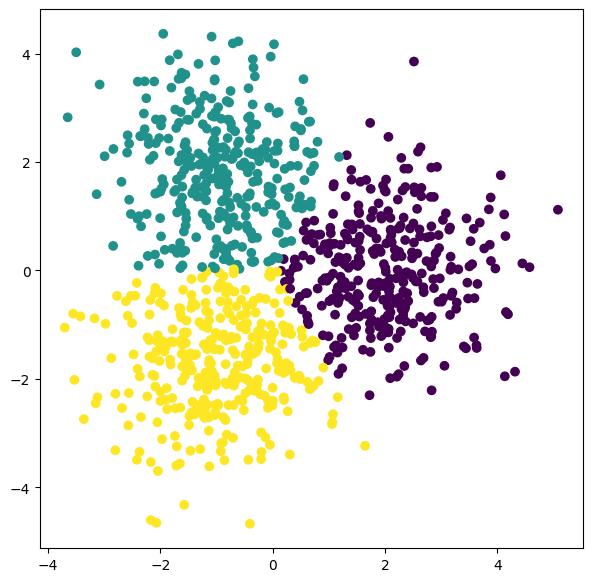

In [14]:
from scipy.optimize import fmin_l_bfgs_b

# TODO
x0 = np.zeros((P + 1) * K)
params_hat, f, d = fmin_l_bfgs_b(
    func = lambda x: negloglik_and_grad(params=x, X=X, Y=Y)[0], 
    x0 = x0, 
    fprime = lambda x: negloglik_and_grad(params=x, X=X, Y=Y)[1]
)
# END TODO

y_proba = predict_proba(params_hat)
plot_data(X, np.argmax(y_proba, axis=1))

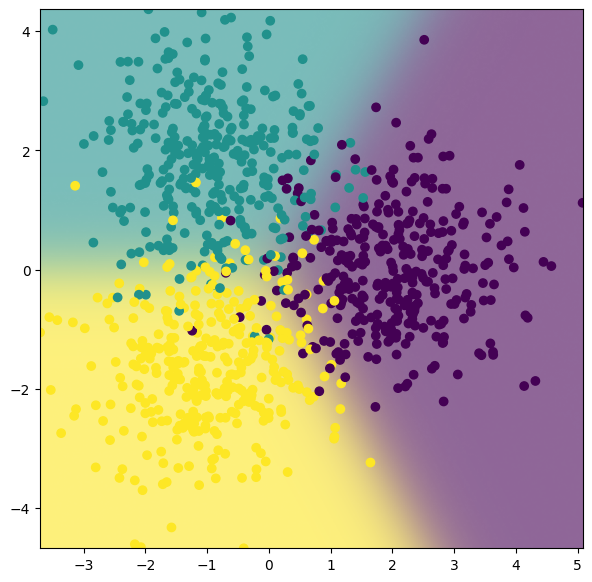

In [15]:
from functools import partial
from utils import show_decision_boundary
show_decision_boundary(partial(predict_proba, params=params_hat), data=(X, Y))

<div class="alert alert-success">
    <b>QUESTION 9:</b>
    <ul>
    <li>
        Wrap this into a function of X, Y and lbda that implements
        the function `multinomial_lbfgs_l2` (Based on $\mathcal{R}_2$ regularization) that will be
        used to get a good value of x_min (minimum of the $\ell_2$ regularized
        model).
    </li>
    </ul>
</div>

Wrap this into a function of X, Y and lbda that implements the function `multinomial_lbfgs_l2` (Based on $\mathcal{R}_2$ regularization) that will be used to get a good value of x_min (minimum of the $\ell_2$ regularized model).

To help you we give you the code of the objective to minimize
in case you use $\ell_1$, $\ell_2$ and $\ell_{21}$ penalties.

In [16]:
def pobj_l1(params, X=X, Y=Y, lbda=1.):
    K = Y.shape[1]
    P = (params.size // K) - 1
    W = params[K:].reshape(P, K)
    return negloglik(params, X=X, Y=Y) + lbda * np.sum(np.abs(W))

def pobj_l2(params, X=X, Y=Y, lbda=1.):
    K = Y.shape[1]
    P = (params.size // K) - 1
    W = params[K:].reshape(P, K)
    return negloglik(params, X=X, Y=Y) + lbda / 2 * np.linalg.norm(W, 'fro') ** 2

def pobj_l21(params, X=X, Y=Y, lbda=1.):
    K = Y.shape[1]
    P = (params.size // K) - 1
    W = params[K:].reshape(P, K)
    return negloglik(params, X=X, Y=Y) + lbda * np.linalg.norm(W, axis=1).sum()

In [17]:
def negloglik_and_grad_l2(params, X=X, Y=Y, lbda=1.):
    """Compute the negative log-likelihood and its gradient with L2 regularization."""
    K = Y.shape[1]
    P = (params.size // K) - 1
    b = params[:K]
    W = params[K:].reshape(P, K)

    # Negative Log-likelihood and its gradient
    loss, grad = negloglik_and_grad(params, X, Y)

    # Add L2 regularization
    loss += lbda / 2 * np.linalg.norm(W, 'fro') ** 2
    grad_W = grad[K:].reshape(P, K) + lbda * W
    grad = np.concatenate([grad[:K], grad_W.ravel()])

    return loss, grad

In [18]:
def multinomial_lbfgs_l2(X=X, Y=Y, lbda=1):
    """Minimize the pobj_l2 function using L-BFGS
    
    Parameters
    ----------
    X : ndarray, shape (N, P)
        input data.
    Y : ndarray, shape (N, K)
        output targets one-hot encoded.
    lbda : float
        The regularization strength.

    Returns
    -------
    params_hat: array, shape (K + K * P,)
        The estimated parameters.
    """
    # TODO
    K = Y.shape[1]
    P = X.shape[1]
    x0 = np.zeros((P + 1) * K)

    params_hat, f, d = fmin_l_bfgs_b(
        func=lambda params: negloglik_and_grad_l2(params, X, Y, lbda)[0],
        x0=x0,
        fprime=lambda params: negloglik_and_grad_l2(params, X, Y, lbda)[1]
    )
    # END TODO
    return params_hat

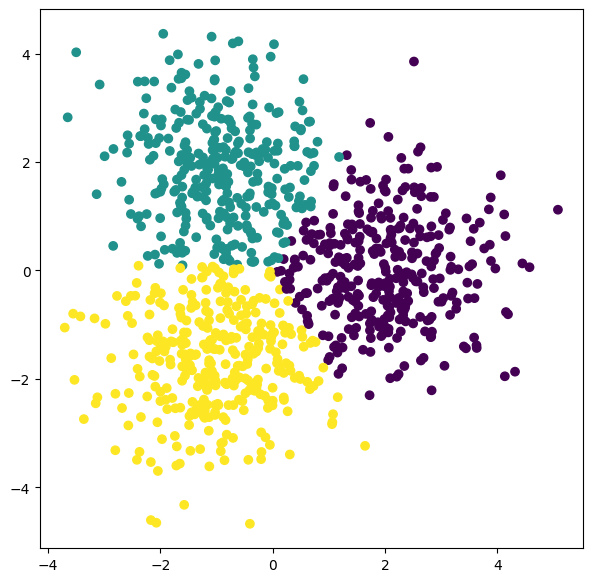

In [19]:
params_hat_l2 = multinomial_lbfgs_l2(X, Y, lbda=1)
y_proba_l2 = predict_proba(params_hat_l2)
plot_data(X, np.argmax(y_proba_l2, axis=1))

Now that we have a gradient of the negative loglikelihood term we can implement other solvers. Namely you are going to implement:

- Proximal Gradient Descent (PGD aka ISTA)
- Accelerated Proximal Gradient Descent (APGD aka FISTA)

Before this we are going to define the `monitor` class previously used in the second lab as well as plotting functions useful to monitor convergence.

**Note:** Below, and following standard optimization notations, we will refer to the parameters of the optimization problem as `x`,  `x_min` and `x_init` for simplicity.

In [20]:
class monitor(object):
    def __init__(self, algo, obj, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.obj = obj
        self.args = args
        if self.x_min is not None:
            self.f_min = obj(x_min, *args)

    def run(self, *algo_args, **algo_kwargs):
        t0 = time.time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time.time() - t0
        self.x_list = x_list
        if self.x_min is not None:
            self.err = [linalg.norm(x - self.x_min) for x in x_list]
            self.obj = [self.obj(x, *self.args) - self.f_min for x in x_list]
        else:
            self.obj = [self.obj(x, *self.args) for x in x_list]


def plot_epochs(monitors, solvers):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    for monit in monitors:
        ax1.semilogy(monit.obj, lw=2)
        if monit.x_min is not None:
            ax1.set_ylabel("$f(x_k) - f(x^*)$")
        else:
            ax1.set_ylabel("$f(x_k)$")
        ax1.set_xlabel("Epoch")
        ax1.set_title("Objective")

    ax1.legend(solvers)

    for monit in monitors:
        if monit.x_min is not None:
            ax2.semilogy(monit.err, lw=2)
            ax2.set_title("Iterates")
            ax2.set_xlabel("Epoch")
            ax2.set_ylabel("$\|x_k - x^*\|_2$")

    ax2.legend(solvers)


def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

<div class="alert alert-success">
    <b>QUESTION 10a:</b>
    <ul>
    <li>
        Implement the proximal gradient descent (PGD) method
    </li>
    </ul>
</div>

The parameter `step` is the size of the gradient step.

In [21]:
def pgd(x_init, grad, prox, n_iter=100, step=1., grad_args=(), prox_args=()):
    """Proximal gradient descent algorithm.
    
    Parameters
    ----------
    x_init : ndarray
        Here the params of shape (K + K*P,)
    grad : callable
        The gradient function.
    prox : callable
        The proximal operator function.
    n_iter : int
        The number of iterations
    step : float
        The step size.
    grad_args : tuple
        Extra parameters to pass to the gradient function
        (eg. X, Y)
    prox_args : tuple
        Extra parameters to pass to the prox function
        (eg. lbda, K)
    
    Returns
    -------
    x_hat : ndarray
        The estimated params.
    x_list : list
        The list of iterates values at each iteration.
    """
    x = x_init.copy()
    x_list = []
    x_list.append(x.copy())
    for i in range(n_iter):
        ### TODO
        x = prox(x - step * grad(x, *grad_args), *prox_args)
        ### END TODO
        x_list.append(x.copy())
    return x, x_list

<div class="alert alert-success">
    <b>QUESTION 10b:</b>
    <ul>
    <li>
        Using the monitor class and the plot_epochs function, display the convergence.
    </li>
    </ul>
</div>

**Note:** You will have to provide a `step` value, which should be theoretially less than `1 / lipschitz_constant`. You will propose a value for it but you are not expected to provide a mathematical proof, unless you think it's a moral duty to give one...

To help you we give you the proximal operator functions for $\ell_1$, $\ell_2$ and $\ell_{21}$ regularized models.

In [22]:
def prox_l1(params, step, lbda, K):
    return prox_R1(params, reg=step * lbda, K=K)

def prox_l2(params, step, lbda, K):
    return prox_R2(params, reg=step * lbda, K=K)

def prox_l21(params, step, lbda, K):
    return prox_R21(params, reg=step * lbda, K=K)

Let's first consider the $\ell_2$ case. You will use the `multinomial_lbfgs_l2` function to obtain a value for `x_min` so that you can display the convergence error on the iterates (ie. $\|x_k - x^*\|$). You will need to pass this `x_min` to the `monitor` function.

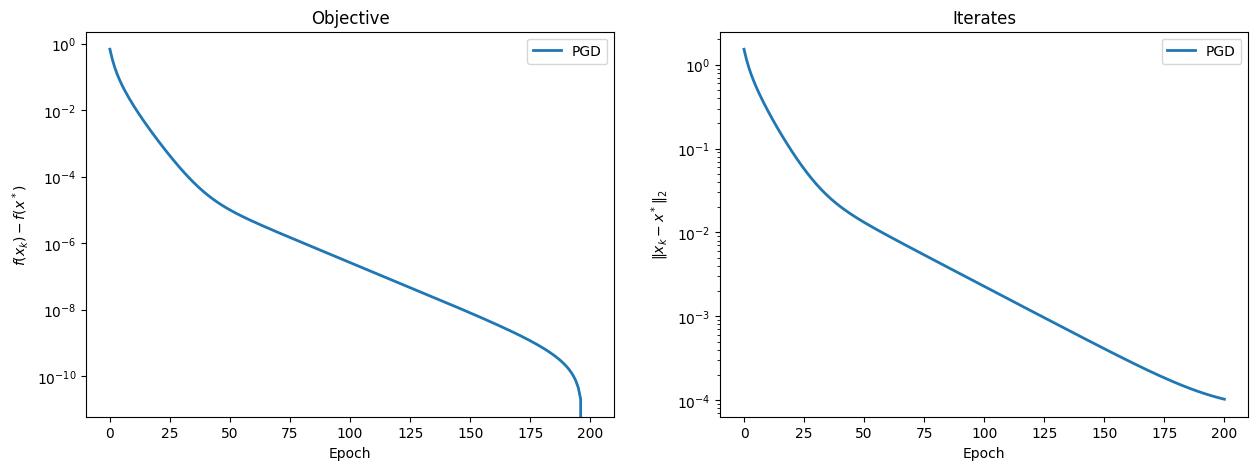

In [23]:
x_init = np.zeros((P + 1) * K)
n_iter = 200
lbda = .1

# TODO
L = linalg.norm(X, ord=2) ** 2 / X.shape[0] #not sure how to get L for multinomial case
step = 1. / L
grad = lambda param, X, Y: negloglik_and_grad(param, X, Y)[1]

xmin_l2 = multinomial_lbfgs_l2(X, Y, lbda=lbda)

monitor_pgd_l2 =  monitor(
    algo=pgd, 
    obj=pobj_l2, 
    x_min=xmin_l2,
    args=(X, Y, lbda))

monitor_pgd_l2.run(
    x_init,
    grad=grad,
    prox=prox_l2,
    n_iter=n_iter,
    step=step,
    grad_args=(X, Y),
    prox_args=(step, lbda, K))
# END TODO

monitors = [monitor_pgd_l2]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

Now for the $\ell_1$ regularization:

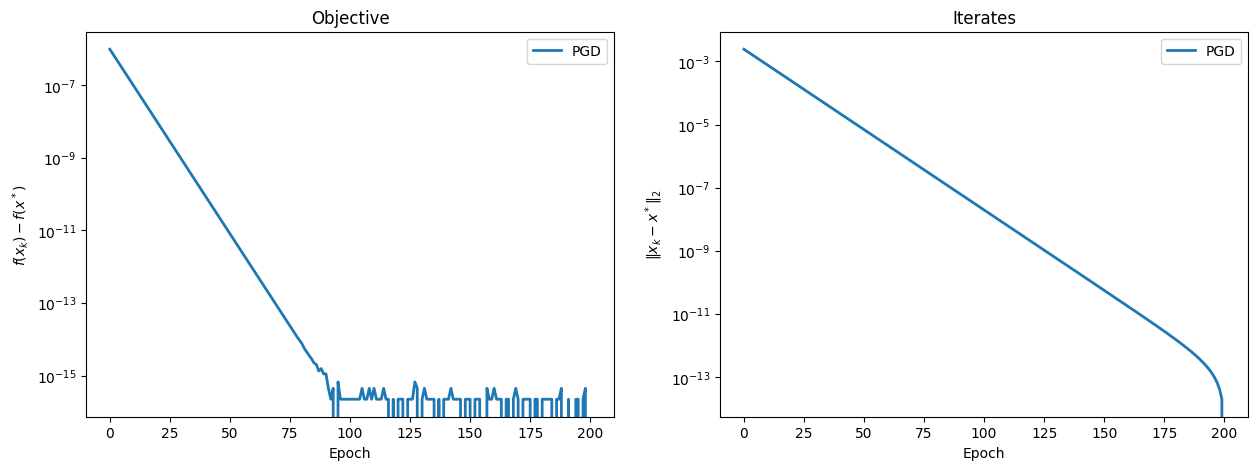

In [24]:
lbda = 1.

# TODO
xmin_l1, _ = pgd(
    x_init=x_init,
    grad=grad,
    prox=prox_l1,
    n_iter=n_iter,
    step=step,
    grad_args=(X, Y),
    prox_args=(step, lbda, K)
)

monitor_pgd_l1 =  monitor(
    algo=pgd, 
    obj=pobj_l1, 
    x_min=xmin_l1, 
    args=(X, Y, lbda)
)

monitor_pgd_l1.run(x_init,
    grad=grad,
    prox=prox_l1,
    n_iter=n_iter,
    step=step,
    grad_args=(X, Y),
    prox_args=(step, lbda, K)
)
# END TODO

monitors = [monitor_pgd_l1]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

Now for the $\ell_{21}$ regularization:

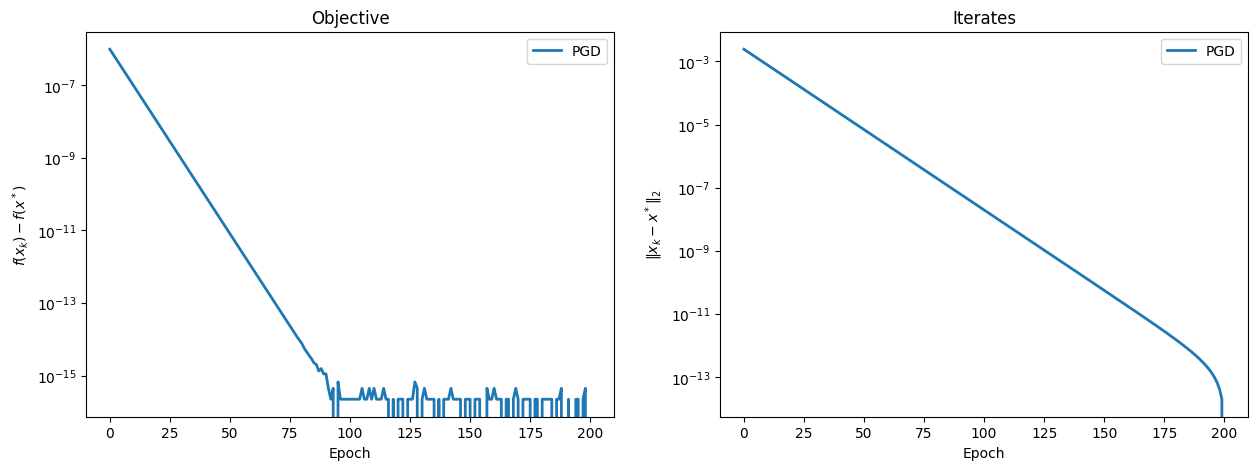

In [25]:
lbda = 1.

# TODO

xmin_l21, _ = pgd(
    x_init=x_init,              
    grad=grad,
    prox=prox_l21,
    n_iter=n_iter,
    step=step,
    grad_args=(X, Y),
    prox_args=(step, lbda, K)
)

monitor_pgd_l21 =  monitor(
    algo=pgd,
    obj=pobj_l21,
    x_min=xmin_l21,
    args=(X, Y, lbda)
)

monitor_pgd_l21.run(
    x_init,
    grad=grad,
    prox=prox_l21,
    n_iter=n_iter,
    step=step,
    grad_args=(X, Y),
    prox_args=(step, lbda, K)
)
# END TODO

monitors = [monitor_pgd_l21]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

<div class="alert alert-success">
    <b>QUESTION 11:</b>
    <ul>
    <li>
        Implement the accelerated proximal gradient descent (APGD) and add this solver to the monitoring plots.
    </li>
    </ul>
</div>

In [26]:
def apgd(x_init, grad, prox, n_iter=100, step=1., grad_args=(), prox_args=()):
    """Accelerated proximal gradient descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        ### TODO
        x_new = prox(y - step * grad(y, *grad_args), *prox_args)
        t_new = (1 + np.sqrt(1 + 4 * t ** 2)) / 2
        y = x_new + ((t - 1) / t_new) * (x_new - x)
        x = x_new
        t = t_new
        ### END TODO
        x_list.append(x.copy())
    return x, x_list

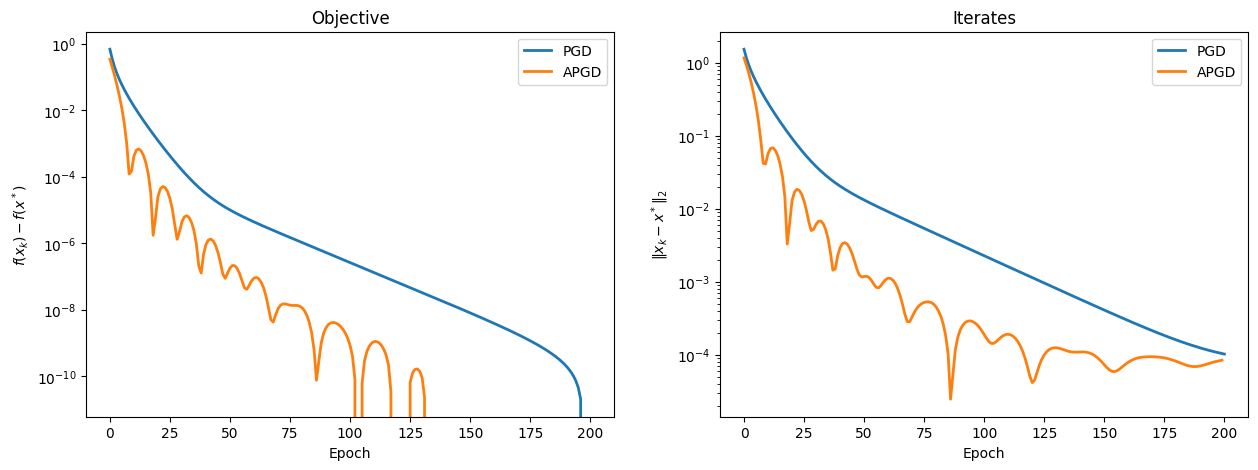

In [27]:
lbda = 0.1

# TODO
monitor_apgd_l2 =  monitor(
    algo=apgd,
    obj=pobj_l2,
    x_min=xmin_l2,
    args=(X, Y, lbda)
)

monitor_apgd_l2.run(
    x_init,
    grad=grad,
    prox=prox_l2,
    n_iter=n_iter,
    step=step,
    grad_args=(X, Y),
    prox_args=(step, lbda, K)
)
# END TODO

monitors = [monitor_pgd_l2, monitor_apgd_l2]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

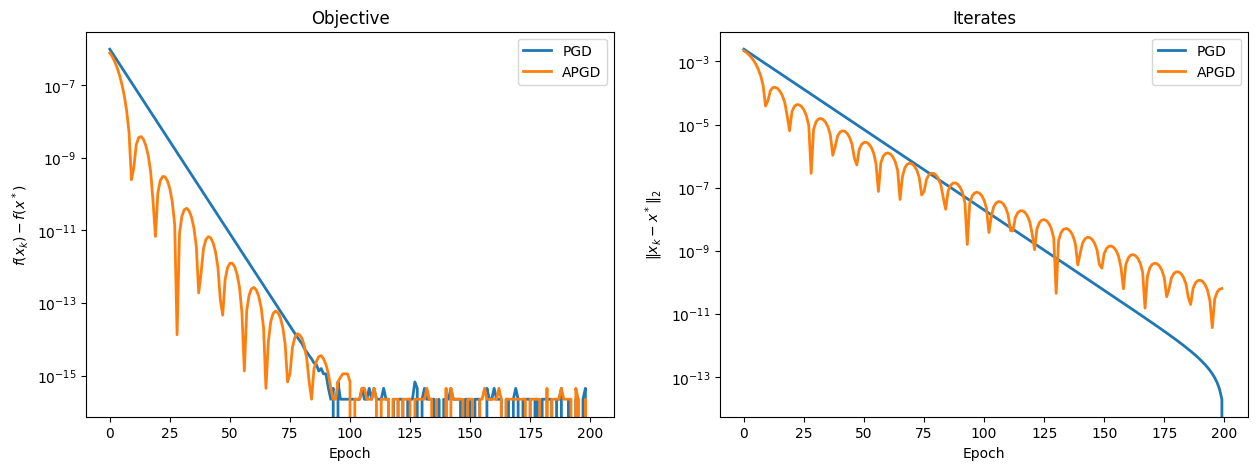

In [28]:
lbda = 1.

# TODO
monitor_apgd_l1 =  monitor(
    algo=apgd,
    obj=pobj_l1,
    x_min=xmin_l1,
    args=(X, Y, lbda)
)

monitor_apgd_l1.run(
    x_init,
    grad=grad,
    prox=prox_l1,
    n_iter=n_iter,
    step=step,
    grad_args=(X, Y),
    prox_args=(step, lbda, K)
)
# END TODO

monitors = [monitor_pgd_l1, monitor_apgd_l1]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

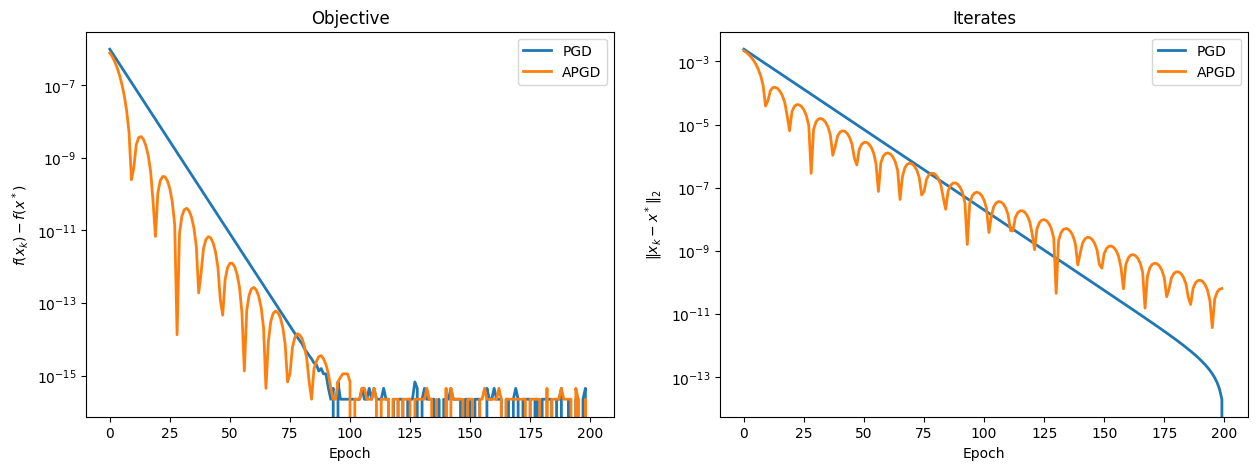

In [29]:
lbda = 1.

# TODO
monitor_apgd_l21 =  monitor(
    algo=apgd,
    obj=pobj_l21,
    x_min=xmin_l21,
    args=(X, Y, lbda)
)

monitor_apgd_l21.run(
    x_init,
    grad=grad,
    prox=prox_l21,
    n_iter=n_iter,
    step=step,
    grad_args=(X, Y),
    prox_args=(step, lbda, K)
)
# END TODO

monitors = [monitor_pgd_l21, monitor_apgd_l21]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

# Part 2: Application

You will now apply your solver to the `digits` dataset from scikit-learn

Let's first inspect the dataset:

In [30]:
from sklearn.datasets import load_digits
X_digits, y_digits = load_digits(return_X_y=True)
X_digits.shape, y_digits.shape, np.unique(y_digits)

((1797, 64), (1797,), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

Each row of X is an 8x8 image of digit:

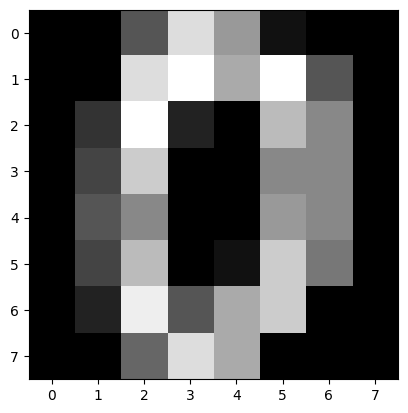

In [31]:
img = X_digits[0].reshape(8, 8)
plt.imshow(img, cmap="gray");

In order to highlight the importance of regularization and especially L1 we are going
to artificially add some random features with pure noise.

In [32]:
X = np.concatenate([X_digits, np.random.randn(len(X_digits), 1000)], axis=1)

Let's do a basic scaling of the features:

In [33]:
from sklearn.preprocessing import scale
X = scale(X)

Now test the functions above with this dataset:

In [34]:
x_init = np.zeros((X.shape[1] + 1) * np.unique(y_digits).size)
Y = OneHotEncoder().fit_transform(y_digits[:, None]).toarray()
print(negloglik(x_init, X=X, Y=Y))
print(negloglik_and_grad(x_init, X=X, Y=Y)[1].shape)

2.302585092994046
(10650,)


In order to facilitate our experiment we're going to write a full scikit-learn estimator.

<div class="alert alert-success">
    <b>QUESTION 12:</b>
    <ul>
    <li>
        Implement the `fit` method from the estimator in the next cell
    </li>
    </ul>
</div>

In [35]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MultinomialLogistic(BaseEstimator, ClassifierMixin):
    """scikit-learn estimator for the MultinomialLogistic model
    
    Parameters
    ----------
    lbda : float
        The regularization parameter
    penalty : 'l1' | 'l2' | 'l21'
        The type of regularization to use.
    max_iter : int
        The number of iterations / epochs to do on the data.
    solver : 'pgd' | 'apgd' | 'lbfgs'
        The type of regularization to use.
        'lbfgs' is only supported with penalty='l2'.
        
    Attributes
    ----------
    W_ : ndarray, shape (n_features, n_classes)
        The weights.
    b_ : ndarray, shape (n_classes,)
        The biases / intercepts.
    """
    def __init__(self, lbda=1., penalty='l2', max_iter=2000,
                 solver='lbfgs'):
        self.lbda = lbda
        self.penalty = penalty
        self.max_iter = max_iter
        self.solver = solver
        assert self.penalty in ['l1', 'l2', 'l21']
        assert self.solver in ['pgd', 'apgd', 'lbfgs']

    def fit(self, X, y):
        """Fit method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target. Must be integers between 0 and n_classes - 1.
        """
        n_classes = int(np.max(y)) + 1
        assert np.all(np.unique(y) == np.arange(n_classes))
        Y = OneHotEncoder().fit_transform(y[:, None]).toarray()
        n_samples, n_features = X.shape
        # TODO
        x_init = np.zeros((n_features+1) * n_classes)
        L = linalg.norm(X) ** 2 / X.shape[0] #not sure how to get L for multinomial case
        step = 1. / L
        grad = lambda param_, X_, Y_: negloglik_and_grad(param_, X_, Y_)[1]

        if self.penalty == 'l1':
            prox = prox_l1
        elif self.penalty == 'l2':
            prox = prox_l2
        elif self.penalty == 'l21':
            prox = prox_l21

        if self.solver == 'lbfgs' and self.penalty == 'l2':
            x = multinomial_lbfgs_l2(X, Y, lbda=self.lbda)
        elif self.solver == 'pgd':
            x, _ = pgd(x_init=x_init,
                       grad=grad, 
                       prox=prox, 
                       n_iter=self.max_iter, 
                       step=step, 
                       grad_args=(X, Y), 
                       prox_args=(step, self.lbda, n_classes))
        elif self.solver == 'apgd':
            x, _ = apgd(x_init=x_init, 
                        grad=grad, 
                        prox=prox, 
                        n_iter=self.max_iter, 
                        step=step, 
                        grad_args=(X, Y), 
                        prox_args=(step, self.lbda, n_classes))
        
        W = x[n_classes:].reshape(-1, n_classes)
        b = x[:n_classes]
        # END TODO
        self.params_ = x
        self.W_ = W
        self.b_ = b
        return self

    def predict(self, X):
        """Predict method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.

        Returns
        -------
        y_pred : ndarray, shape (n_samples,)
            The predicted target.
        """
        return np.argmax(self.predict_proba(X), axis=1)

    def predict_proba(self, X):
        """Predict proba method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.

        Returns
        -------
        y_proba : ndarray, shape (n_samples, n_classes)
            The predicted probabilities.
        """
        return predict_proba(self.params_, X)


for solver in ['pgd', 'apgd', 'lbfgs']:
    clf = MultinomialLogistic(lbda=1., penalty='l2', max_iter=1000, solver=solver)
    clf.fit(X, y_digits)
    print('Solver with L2: %s   -   Score : %s' % (solver, clf.score(X, y_digits)))

for solver in ['pgd', 'apgd']:
    clf = MultinomialLogistic(lbda=.01, penalty='l1', max_iter=1000, solver=solver)
    clf.fit(X, y_digits)
    print('Solver with L1: %s   -   Score : %s' % (solver, clf.score(X, y_digits)))
    
for solver in ['pgd', 'apgd']:
    clf = MultinomialLogistic(lbda=.01, penalty='l21', max_iter=1000, solver=solver)
    clf.fit(X, y_digits)
    print('Solver with L21: %s   -   Score : %s' % (solver, clf.score(X, y_digits)))

Solver with L2: pgd   -   Score : 0.9638286032276016
Solver with L2: apgd   -   Score : 0.9788536449638287
Solver with L2: lbfgs   -   Score : 0.9782971619365609
Solver with L1: pgd   -   Score : 0.889259877573734
Solver with L1: apgd   -   Score : 0.9521424596549806
Solver with L21: pgd   -   Score : 0.9404563160823595
Solver with L21: apgd   -   Score : 0.9782971619365609


<div class="alert alert-success">
    <b>QUESTION 13:</b>
    <ul>
    <li>
        Compare the performance of your model on test data when varying
        the penalty among $\ell_2$, $\ell_1$ and $\ell_{21}$ for a grid of lambda values. Comment on what you see on the curves.
    </li>
    </ul>
</div>

Compare the performance of your model on test data when varying
        the penalty among $\ell_2$, $\ell_1$ and $\ell_{21}$ for a grid of lambda values. Comment on what you see on the curves.

In [36]:
from sklearn.model_selection import train_test_split
import pandas as pd

X_train, X_test, y_train, y_test = train_test_split(X, y_digits, random_state=42)
lbda_grid = np.geomspace(1e-4, 1e2, 8)

# TODO
scores = []
penalties = ['l1', 'l2', 'l21']
solvers = ['pgd', 'apgd', 'lbfgs']
index_penalties = ['l1', 'l1', 'l2', 'l2', 'l21', 'l21']*2 + ["l2", "l2"]
labels = []
for penalty in penalties:
    for solver in solvers:
        cur_score_train = []
        cur_score_test = []
        if not(solver == "lbfgs" and not(penalty == "l2")):
            for lbda in lbda_grid:
                clf = MultinomialLogistic(lbda=lbda, penalty=penalty, max_iter=1000, solver=solver)
                clf.fit(X_train, y_train)
                cur_score_train.append(clf.score(X_train, y_train))
                cur_score_test.append(clf.score(X_test, y_test))
            scores.append(cur_score_train)
            scores.append(cur_score_test)
            labels.append(f"{penalty} {solver} train")
            labels.append(f"{penalty} {solver} test")

format_scores = pd.DataFrame(np.array(scores), index=index_penalties, columns=lbda_grid)

# END TODO

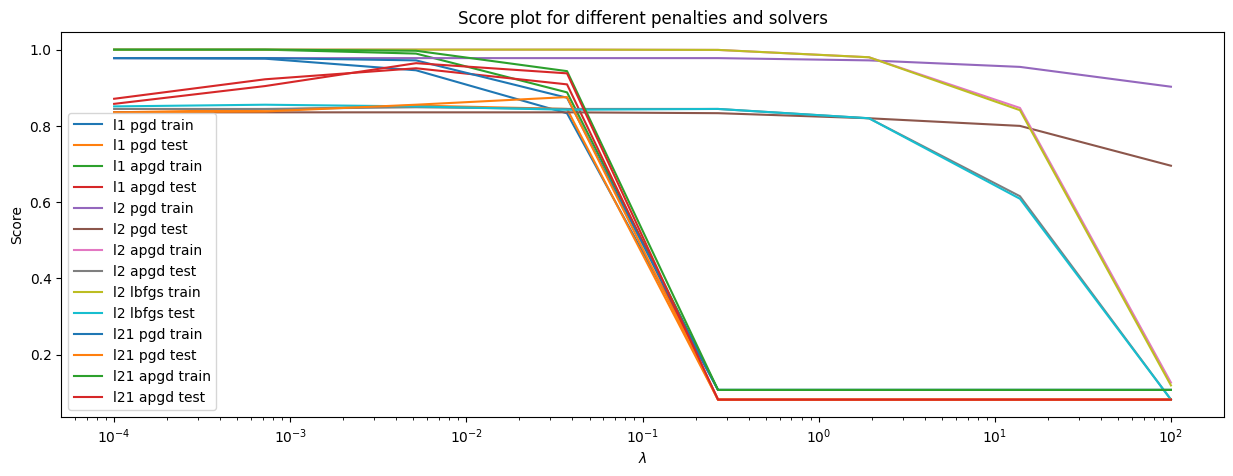

In [37]:
plt.figure(figsize=(15, 5))
plt.plot(format_scores.T, label=labels)
plt.title("Score plot for different penalties and solvers")
plt.xscale("log")
plt.xlabel("$\lambda$")
plt.ylabel("Score")
plt.legend(loc='best')
plt.show()

On the above figure, we can denote 3 kind of score behavior with respect to the regularization factor $\lambda$ : 
- At $\lambda \approx 10^{-1}$ : Most solvers score rapidly fall down to zero. This in the major inflexion point on the graph.
- At $\lambda \approx 1$ : APGD with l2 regularization's performance also begin to fall appart.
- L2 PGD and L2 LBFGS don't see there perfomance tremendously diminish with the lambda values we selected.

Finally, the global trend is the reduction of perfomance as $\lambda$ goes to zero which is expected as the regularization drags parameter to zero. When this point is reached, the model isn't able to perform any sensible prediction anymore.

Consequently, this graph can help us balance model performance and overfitting mitigation by selecting values of $\lambda$ right at the score curve inflection point of the model of interest.

# Part 3 (bonus): Implement block-coordinate descent

<div class="alert alert-success">
    <b>QUESTION 14:</b>
    <ul>
    <li>
        Implement a proximal block-coordinate descent algorithm and add this solver to the monitoring plots.
    </li>
    </ul>
</div>

**HINT:** The easiest way is to use block updates where you update iteratively for each pass over the data first `b` and then each row of `W`.

In [38]:
### TODO

### END TODO